In [1]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.9 MB/s eta 0:00:00


In [7]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16 as Model

In [9]:
# VGG16 - это известная архитектура нейронной сети, предназначенная для классификации изображений.
from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Загружаем модель VGG16:
# - weights='imagenet' означает, что модель будет загружена с предобученными весами на датасете ImageNet.
model = Model(weights='imagenet', include_top=True)

model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from google.colab import files
files.upload()

Saving Mona_Lisa.jpg to Mona_Lisa.jpg
Saving Madona_Benua.jpg to Madona_Benua.jpg
Saving Madona_Lita.jpg to Madona_Lita.jpg
Saving Madona_v_skalax.jpg to Madona_v_skalax.jpg


{'Mona_Lisa.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xdb\x00C\x01\x03\x03\x03\x04\x03\x04\x08\x04\x04\x08\x10\x0b\t\x0b\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\x10\xff\xc0\x00\x11\x08\x00\xf4\x00\xf4\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1d\x00\x00\x02\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x03\x06\x07\x02\x08\x01\x00\t\xff\xc4\x00A\x10\x00\x02\x01\x02\x04\x04\x03\x05\x06\x04\x05\x03\x04\x03\x00\x00\x01\x02\x03\x04\x11\x00\x05\x12!\x061AQ\x13"a\x07q\x81\x91\xa1\x14#2\xb1\xc1\xf0\x08B\xd1\xe1\x153Rb\xf1\x16$%Cr\x

Madona_Benua.jpg  Madona_Lita.jpg  Madona_v_skalax.jpg	Mona_Lisa.jpg  sample_data


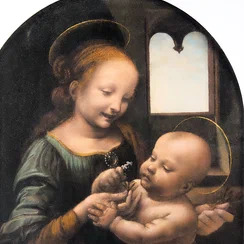

In [21]:
!ls
from IPython.display import Image
Image('Madona_Benua.jpg')

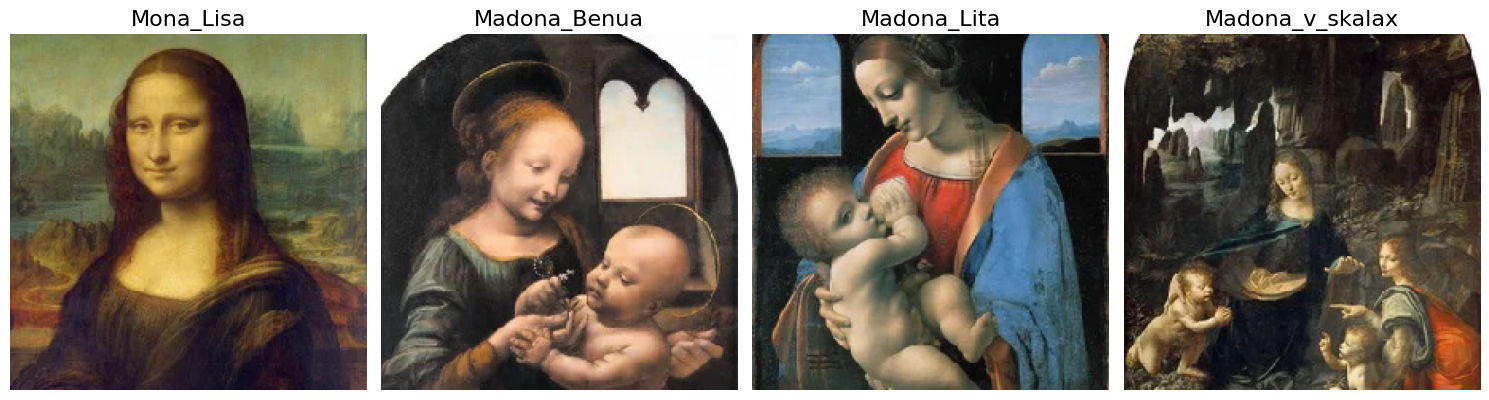

In [24]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

# Загружаем предобученную модель VGG16 с весами ImageNet:
model = Model(weights='imagenet', include_top=True)
# Создадим списки изображений и путей к ним для загрузки:
imgTitleList = ['Mona_Lisa', 'Madona_Benua', 'Madona_Lita', 'Madona_v_skalax']
imgPathList = ['Mona_Lisa.jpg', 'Madona_Benua.jpg', 'Madona_Lita.jpg', 'Madona_v_skalax.jpg']
# Загружаем изображения:
imgArr = np.asarray([np.array(load_img(imgPath, target_size=(224, 224))) for imgPath in imgPathList])
# Предобрабатываем изображения для подачи в модель (нормализация и изменение формата):
X = preprocess_input(imgArr)
# Визуализируем изображений:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for i, title in enumerate(imgTitleList):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(imgArr[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [25]:

replace2linear = ReplaceToLinear()
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear
score = CategoricalScore([726, 895, 726, 726])
def score_function(output):
    return (output[0][726], output[1][895], output[2][726], output[3][726])

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_184
Received: inputs=['Tensor(shape=(4, 224, 224, 3))']
  warnings.warn(msg)


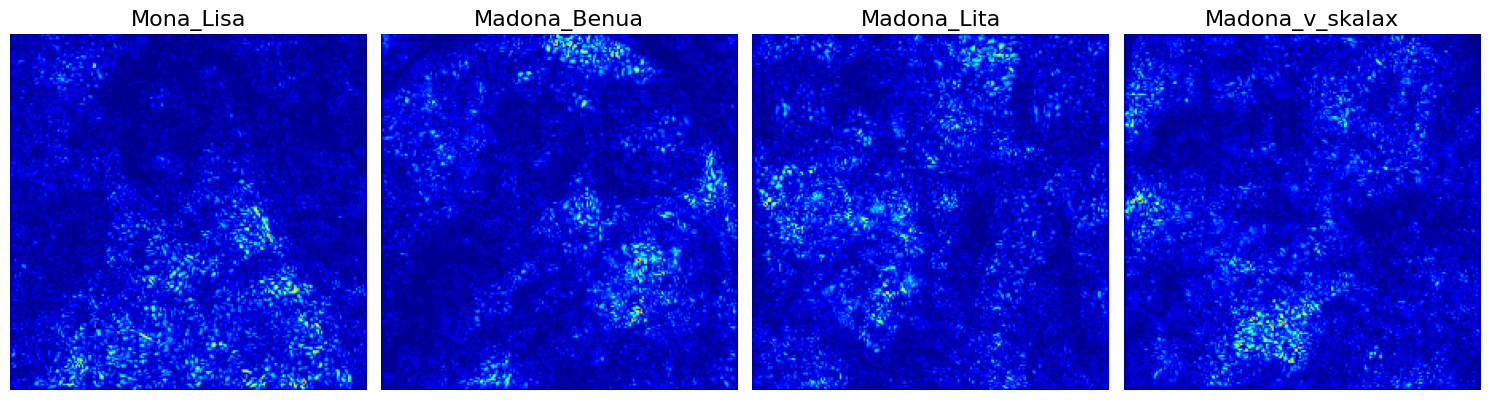

In [26]:
saliency = Saliency(model, model_modifier=replace2linear, clone=True)
mapList = saliency(score, X)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for i, title in enumerate(imgTitleList):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(mapList[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

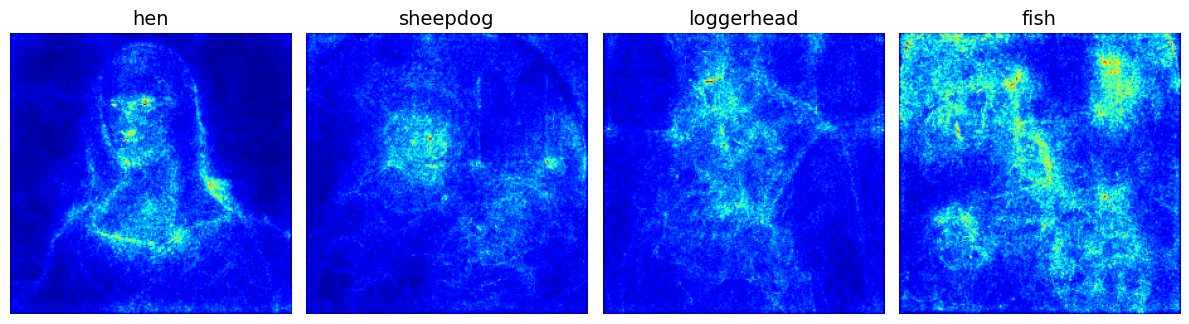

In [27]:
saliency_map = saliency(score, X, smooth_samples=20, smooth_noise=0.20)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('smoothgrad.png')
plt.show()

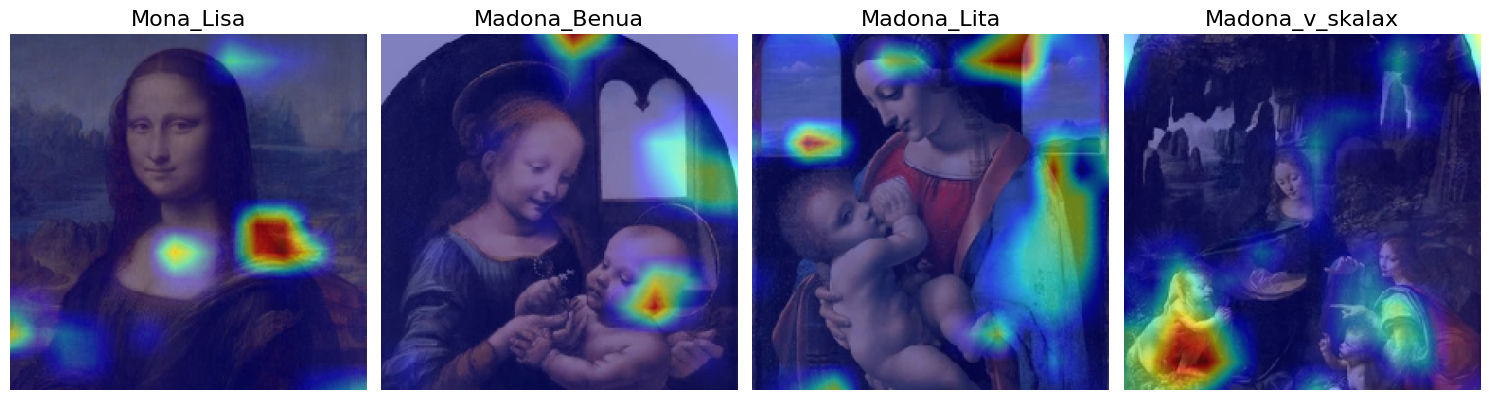

In [28]:
gradcam = Gradcam(model, model_modifier=replace2linear, clone=True)
mapList = gradcam(score, X, penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for i, title in enumerate(imgTitleList):
    heatmap = np.uint8(cm.jet(mapList[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(imgArr[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

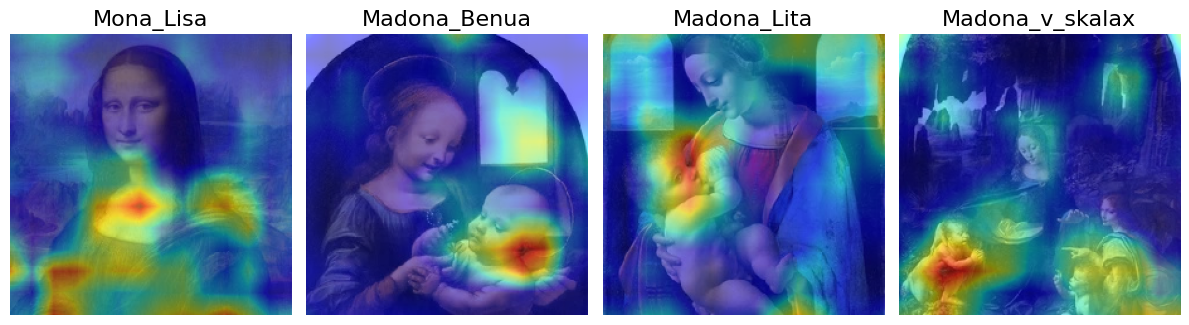

In [29]:
gradcam = GradcamPlusPlus(model, model_modifier=replace2linear, clone=True)
mapList = gradcam(score, X, penultimate_layer=-1)
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(imgTitleList):
    heatmap = np.uint8(cm.jet(mapList[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(imgArr[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()